# Dueling Double Deep Q Network (DDDQN)

## Basic Imports

In [1]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import gym
import random
import torch
from IPython import display
from collections import namedtuple

import torch
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

!pip install box2d

## Memory - Replay Buffer

In [2]:
class Replay_Buffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.buffer = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):        
         experience = self.experience(state, action, reward, next_state, done)
         self.buffer.append(experience)
    
    def sample(self):
        indices = np.random.choice(len(self.buffer), self.batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[idx] for idx in indices])
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards, dtype=np.float32)
        next_states = np.array(next_states)
        dones = np.array(dones, dtype=np.uint8)
        return (states, actions, rewards, next_states, dones)
       
    def __len__(self):
        return len(self.buffer)

# Dueling Double Deep Q Network

In [3]:
class DuelingQNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, seed):
        super(DuelingQNetwork, self).__init__() #Because we use the nn.Module
        self.seed = torch.manual_seed(seed)
        
        # Set the feature layer with its activation functions
        self.feature_layers = nn.Sequential(nn.Linear(state_size, 256)
                                            , nn.ReLU() 
                                            , nn.Linear(256, 128)
                                            , nn.ReLU() 
                                            , nn.Linear(128, 128) 
                                            , nn.ReLU())
        
        # Set the advantage layer with its activation functions
        self.advantage_layers = nn.Sequential(nn.Linear(128, 128)
                                             , nn.ReLU()
                                             , nn.Linear(128, action_size))
        
        # Set the value layer with its activation functions
        self.value_layers = nn.Sequential(nn.Linear(128, 128)
                                          , nn.ReLU()
                                          , nn.Linear(128, 1))
        
    def forward(self, state):
        feature = self.feature_layers(state)
        advantage = self.advantage_layers(feature)
        value = self.value_layers(feature)
        action = value + advantage - advantage.mean()
        return action

## Agent

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    def __init__(self, state_size, action_size, seed, buffer_size = 1000000, batch_size = 64, target_update_per_steps = 4,
                  gamma = 0.996, alpha = 0.0005, tau = 0.01):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.buffer = Replay_Buffer(action_size, buffer_size, batch_size, seed)
        self.batch_size = batch_size
        self.target_update_per_steps = target_update_per_steps
        self.gamma = gamma
        self.alpha = alpha
        self.tau = tau

        # Online network for action selection
        self.q_network_main = DuelingQNetwork(state_size, action_size, seed).to(device)
        # Target network for action evaluation 
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        # Adam stochastic optimization algorithm for network weights update
        self.optimizer = optim.Adam(self.q_network_main.parameters(), lr=self.alpha)

        # Initialize time step (for updating every target_update_per_steps)
        self.t_step = 0

    def action_selection(self, state, epsilon=0.):
        
        # select action from the input state
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.q_network_main.eval()
        # operations of the block have no gradients
        with torch.no_grad():
            action_values = self.q_network_main(state)
        self.q_network_main.train()

        # Epsilon-greedy action selection
        random_num = random.random()
        if random_num > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def execute_action(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.buffer.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.target_update_per_steps
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.buffer) > self.batch_size:
                experiences = self.buffer.sample()
                self.learn_DDQN(experiences)

    
    def learn_DDQN(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        # Convert array to torch tensors
        states = torch.tensor(np.array(states, copy=False)).to(device)
        actions = torch.tensor(actions).to(device)
        rewards = torch.tensor(rewards).to(device)
        next_states = torch.tensor(np.array(next_states, copy=False)).to(device)
        dones = torch.BoolTensor(dones).to(device)

        actions = actions.unsqueeze(-1)
        q_vals = self.q_network_main(states).gather(1, actions.long())
        q_vals = q_vals.squeeze(-1)
        # operations of the block have no gradients
        with torch.no_grad():
            next_state_acts = self.q_network_main(next_states).max(1)[1]
            next_state_acts = next_state_acts.unsqueeze(-1)
            next_state_vals = self.qnetwork_target(next_states).gather(1, next_state_acts).squeeze(-1)
            next_state_vals[dones] = 0.0
            exp_q_vals = rewards + self.gamma*next_state_vals.detach()
        
        loss = F.mse_loss(exp_q_vals, q_vals)         # Computing the loss value
        self.optimizer.zero_grad()                    # Loss minimization
        loss.backward()
        self.optimizer.step()

        # Update the target network using Soft Update
        self.soft_update(self.q_network_main, self.qnetwork_target)  

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)


# Main Part

## Initialize the Agent's Environment

In [5]:
env = gym.make('LunarLander-v2')
env.seed(0) #Set a Random Seed of the Environment
print('Actions available for the agent: ', env.action_space.n)

print('The shape of the State: ', env.observation_space.shape)

pass

Actions available for the agent:  4
The shape of the State:  (8,)


/Users/kgkolias/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
agent = Agent(state_size=8, action_size=4, seed=0)

start_time= time.time()

def train_agent(num_episodes=1000, max_timesteps_per_ep=1000, max_epsilon=1.0, min_epsilon=0.1, eps_decay=0.99):
    
    # All the payoffs (rewards) per episode 
    payoffs = []
    # The last 100 rewards to a linked list
    payoffs_window = deque(maxlen=100)
    # Epsilon initialization
    epsilon = max_epsilon              
    sum_payoffs = 0
    
    #for loop for the episodes
    for i in range(1, num_episodes+1):
        state = env.reset()
        payoff = 0
        
        for t in range(max_timesteps_per_ep):
            action = agent.action_selection(state, epsilon) #the agent selects an action 
            next_state, reward, done, _ = env.step(action) #find the reward and the next state based on the selected action
            agent.execute_action(state, action, reward, next_state, done)  #action execution
            state = next_state #replace the current state with the next state
            payoff += reward #calculate the payoff
            if done:
                break 
        
        # Append the episode reward to the linked list
        payoffs_window.append(payoff)
        # Append the last payoff to the list
        payoffs.append(payoff)
        # decrease epsilon
        epsilon = eps_decay*epsilon       
        
        #Calculations for total average reward
        if(i%100 == 0):
            num_averages = i//100 
            sum_payoffs += np.mean(payoffs_window)
        else:
            sum_payoffs += np.mean(payoffs_window)
            num_averages = (i//100)+1
            
        print('\rEpisode {}\tMean payoff: {:.2f}'.format(i, np.mean(payoffs_window)), end="")
        if i % 100 == 0:
            print('\rEpisode {}\tMean payoff: {:.2f}'.format(i, np.mean(payoffs_window)))
            
        #If the mean reward of the last 100 episodes is equal or greater than 200, the environment has been solved    
        if np.mean(payoffs_window)>=200.0:
            average_payoff = sum_payoffs/num_averages
            
            print('\n The environment has been solved in {:d} episodes'.format(i))
            
            #Saving the weights of the network in the relative file
            torch.save(agent.q_network_main.state_dict(), 'dddqn_checkpoint.pth')
            break
    return payoffs

#Call the previous function to save the returned payoffs
payoffs = train_agent()

end_time = time.time()

#Calculate the elapsed time for the analysis
elapsed_time = end_time-start_time

Episode 100	Mean payoff: -100.19
Episode 200	Mean payoff: 78.578
Episode 252	Mean payoff: 200.44
 The environment has been solved in 252 episodes


## Plot the rewards

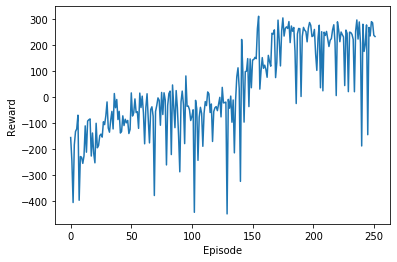

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(payoffs)), payoffs)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [8]:
print('Elapsed Time' ,elapsed_time/60, 'minutes')

Elapsed Time 5.252931948502859 minutes


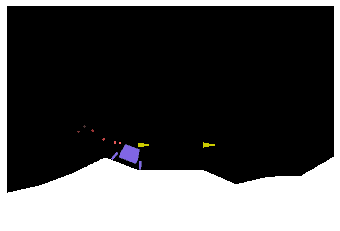

In [9]:
agent = Agent(state_size=8, action_size=4, seed=0)
# load the weights from file
agent.q_network_main.load_state_dict(torch.load('dddqn_checkpoint.pth', map_location=lambda storage, loc: storage))

state = env.reset()
#renderer
img = plt.imshow(env.render(mode='rgb_array'))
for j in range(200):
    action_chosen = agent.action_selection(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action_chosen)
    if done:
        break 
            
env.close()